# PYTORCH

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#import logger
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
import os
import time

In [2]:
print(torch.__version__)

1.7.0


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA = torch.cuda.is_available()
print(CUDA)

True


In [4]:
# Hyper-parameters
sequence_length = 45 # height img
input_size = 45 # width img
hidden_size = 128
num_layers = 2
num_classes = 10
BATCH_SIZE = 256
NUM_WORKERS = 4
EPOCH_NUM = 100
LR = 0.001
SAVE_PATH = 'saved_model'

In [5]:
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [6]:
# MNIST dataset
mnist_transforms=[
            transforms.Resize((input_size, sequence_length)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),]
            #ReshapeTransform((45,45))]

train_dataset = datasets.MNIST(root='dataset', train=True, transform=transforms.Compose(mnist_transforms), download=True)
test_dataset = datasets.MNIST(root='dataset', train=False, transform=transforms.Compose(mnist_transforms))

# Data loader
train_loader = data_utils.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
test_loader = data_utils.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

In [7]:
#train_data = train_dataset.data.cpu().numpy()
#train_data = np.resize(train_data,(60000,1,45,45))
print(train_dataset.data.shape)
print(test_dataset.data.shape)
#print(len(train_tensor), train_tensor[0][0].shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(type(labels))
print(images.shape)
print(labels.shape)

dataiter = iter(test_loader)
images, labels = dataiter.next()
print(type(images))
print(type(labels))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([256, 1, 45, 45])
torch.Size([256])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([256, 1, 45, 45])
torch.Size([256])


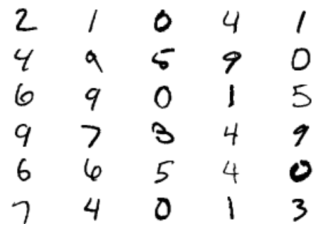

In [9]:
figure = plt.figure()
for index in range(1, 31):
    plt.subplot(6, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(-1, x.size(1) * x.size(2) * x.size(3))

In [11]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
  def __init__(self, batch_size, sequence_length, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.sequence_length = sequence_length
    self.input_size = input_size
    # (batch_dim, seq_length, input_size)
    self.lstm = nn.LSTM(self.input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    x = x.view(-1, self.sequence_length, self.input_size) # (32, 1, 45, 45) => (32, 45, 45)
    # Set initial hidden and cell states : (layer_dim, batch_size, hidden_dim)
    h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
    
    # Forward propagate LSTM
    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

In [12]:
# Training function for baseline net and AttNet, but NOT for RecNet
def train(train_loader, model, criterion, optimizer, epoch):
    load_time = 0
    batch_time = 0
        
    cumul_loss = 0
    cumul_acc = 0
    end = time.time()
    for i, (batch_inputs, batch_labels) in enumerate(train_loader):
        batch_inputs = Variable(batch_inputs)
        batch_labels = Variable(batch_labels)
        if CUDA:
            batch_inputs = batch_inputs.cuda()
            batch_labels = batch_labels.cuda()
        load_time += time.time() - end
        
        batch_logits = model(batch_inputs)
        loss = criterion(batch_logits, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(batch_logits, dim=1)
        acc = torch.mean(torch.eq(pred, batch_labels).float())
        
        cumul_loss += loss
        cumul_acc += acc
        
        batch_time += time.time() - end
        end = time.time()
    
    avg_loss = cumul_loss / len(train_loader)
    avg_loss = avg_loss.data.cpu().numpy()
    avg_acc = cumul_acc / len(train_loader)
    avg_acc = avg_acc.data.cpu().numpy()
    
    return avg_loss, avg_acc, load_time, batch_time

In [13]:
def validate(data_loader, model, criterion):
    cumul_loss = 0.
    cumul_acc = 0.
    for i, (batch_inputs, batch_labels) in enumerate(data_loader):
        batch_inputs = Variable(batch_inputs)
        batch_labels = Variable(batch_labels)
        if CUDA:
            batch_inputs = batch_inputs.cuda()
            batch_labels = batch_labels.cuda()
        
        batch_logits = model(batch_inputs)
        loss = criterion(batch_logits, batch_labels)
        _, pred = torch.max(batch_logits, dim=1)
#         print("Pred, ", pred)
        acc = torch.mean(torch.eq(pred, batch_labels).float())
#         print("Acc, ", acc)
        
        cumul_loss += loss
        cumul_acc += acc
    
    avg_loss = cumul_loss / len(data_loader)
    avg_loss = avg_loss.data.cpu().numpy()
    avg_acc = cumul_acc / len(data_loader)
    avg_acc = avg_acc.data.cpu().numpy()
    
    return avg_loss, avg_acc

In [14]:
model = RNN(BATCH_SIZE, sequence_length, input_size, hidden_size, num_layers, num_classes).to(device)

#summary(model, (1,28,28))
print(model)

RNN(
  (lstm): LSTM(45, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
test_interval = 10
decay_interval = 30

In [16]:
for epoch in range(EPOCH_NUM):
    decay_times = epoch // decay_interval
    lr = LR * 0.1 ** decay_times
    for para_group in optimizer.param_groups:
        para_group['lr'] = lr
    
    avg_loss, avg_acc, load_time, batch_time = train(train_loader, model, criterion, optimizer, epoch)
    print("Epoch {}, Lr {}, Loss: {}, Acc: {}, load_time: {}, batch_time: {}".format(epoch+1, lr, avg_loss, avg_acc, load_time, batch_time))
    
    if (epoch+1) % test_interval == 0:
        save_path = os.path.join(SAVE_PATH, 'rnn_net')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        file_name = os.path.join(save_path, 'rnn_net_' + str(epoch)+'.pth')
        torch.save({
            'epoch': epoch,
            'lr':lr,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }, file_name)
        print('Model saved at '+file_name)

        print("Testing...")
        test_loss, test_acc = validate(test_loader, model, criterion)
        print("Loss {}, Acc {}".format(test_loss, test_acc))

Epoch 1, Lr 0.001, Loss: 0.7092681527137756, Acc: 0.7602163553237915, load_time: 1.5732755661010742, batch_time: 2.7765262126922607
Epoch 2, Lr 0.001, Loss: 0.13196535408496857, Acc: 0.9603365659713745, load_time: 1.4991371631622314, batch_time: 2.729403495788574
Epoch 3, Lr 0.001, Loss: 0.0924338847398758, Acc: 0.9726062417030334, load_time: 1.5581178665161133, batch_time: 2.7951912879943848
Epoch 4, Lr 0.001, Loss: 0.06848962604999542, Acc: 0.979266881942749, load_time: 1.5919651985168457, batch_time: 2.875765562057495
Epoch 5, Lr 0.001, Loss: 0.056363545358181, Acc: 0.9831564426422119, load_time: 1.614281415939331, batch_time: 2.7922263145446777
Epoch 6, Lr 0.001, Loss: 0.0466543585062027, Acc: 0.986177921295166, load_time: 1.5714421272277832, batch_time: 2.820993661880493
Epoch 7, Lr 0.001, Loss: 0.04084867238998413, Acc: 0.9876970052719116, load_time: 1.6566405296325684, batch_time: 2.8998801708221436
Epoch 8, Lr 0.001, Loss: 0.030676431953907013, Acc: 0.9907018542289734, load_tim

Epoch 58, Lr 0.0001, Loss: 7.460854976670817e-05, Acc: 0.9999833703041077, load_time: 1.5163629055023193, batch_time: 2.7357661724090576
Epoch 59, Lr 0.0001, Loss: 6.631350697716698e-05, Acc: 0.9999833703041077, load_time: 1.547715187072754, batch_time: 2.7718708515167236
Epoch 60, Lr 0.0001, Loss: 5.759199848398566e-05, Acc: 0.9999833703041077, load_time: 1.7125520706176758, batch_time: 2.7399356365203857
Model saved at saved_model/rnn_net/rnn_net_59.pth
Testing...
Loss 0.049245238304138184, Acc 0.9910857677459717
Epoch 61, Lr 1.0000000000000003e-05, Loss: 4.872486897511408e-05, Acc: 1.0, load_time: 1.5921859741210938, batch_time: 2.826850652694702
Epoch 62, Lr 1.0000000000000003e-05, Loss: 4.7748770157340914e-05, Acc: 1.0, load_time: 1.5267045497894287, batch_time: 2.692265033721924
Epoch 63, Lr 1.0000000000000003e-05, Loss: 4.689364868681878e-05, Acc: 1.0, load_time: 1.6229870319366455, batch_time: 2.9181323051452637
Epoch 64, Lr 1.0000000000000003e-05, Loss: 4.597884981194511e-05, 